In [589]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.utils import shuffle
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16
import collections
import time
import math
from sklearn.decomposition import PCA

In [30]:
# Create Training Data
path = './OULP-C1V2_Pack/OULP-GEI-(64x64)-5f-full_add_more_data_model/decoded_probe_5f-full_3'

Seq = np.ndarray([1000,64,64], dtype=float)
for ii in range(1, 1001):
    seq_path = path + '/' + str(ii) + '.png'
    Seq[ii-1] = imread(seq_path)

In [31]:
with open('../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq01', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [132]:
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

gallery_5f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_Seq00', mode='rb'))
probe_5f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_Seq01', mode='rb'))

gallery_5f_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_2_Seq00', mode='rb'))
probe_5f_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_2_Seq01', mode='rb'))

gallery_5f_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_3_Seq00', mode='rb'))
probe_5f_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f_3_Seq01', mode='rb'))

pred_gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_Seq00', mode='rb'))
pred_probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_Seq01', mode='rb'))
pred_gallery_full_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_2_Seq00', mode='rb'))
pred_probe_full_2 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_2_Seq01', mode='rb'))
pred_gallery_full_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq00', mode='rb'))
pred_probe_full_3 = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_5f-full_3_Seq01', mode='rb'))

In [133]:
# 5f
gallery_5f = gallery_5f[2146:, 3]
probe_5f = probe_5f[2146:, 3]

gallery_5f_2 = gallery_5f_2[2146:, 3]
probe_5f_2 = probe_5f_2[2146:, 3]

gallery_5f_3 = gallery_5f_3[2146:, 3]
probe_5f_3 = probe_5f_3[2146:, 3]

# full
gallery_full = gallery_full[2146:, 3]
probe_full = probe_full[2146:, 3]

In [137]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

gallery_5f = gallery_5f/float(255)
probe_5f = probe_5f/float(255)

gallery_5f_2 = gallery_5f_2/float(255)
probe_5f_2 = probe_5f_2/float(255)

gallery_5f_3 = gallery_5f_3/float(255)
probe_5f_3 = probe_5f_3/float(255)

# Calculate possible L2 distance

In [594]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))
    
def cal_FAR_FRR(targets, preds):
    '''
    client represents perfect match pairs
    impostor represents false match pairs
    '''
    count_false_rejection  = 0
    count_false_acceptance = 0
    count_client = 0
    count_impostor = 0
    for target,pred in zip(targets, preds):
        if int(target) == 1:
            count_client += 1
            if int(pred) == 0:
                count_false_rejection += 1 
                
        if int(target) == 0:
            count_impostor += 1
            if int(pred) == 1 and int(target) == 0:
                count_false_acceptance += 1
    
    FAR = count_false_acceptance/float(count_impostor) * 100
    FRR = count_false_rejection/float(count_client) * 100
    
    return FAR, FRR

def select_k(max_k, L2_fit, target_fit, L2_test, target_test):
    '''
    calculate the best K
    '''
    from sklearn.neighbors import KNeighborsClassifier
    min_FAR = 10000
    min_FRR = 10000
    K = 1
    for ii in range(1, max_k + 1):
        neigh = KNeighborsClassifier(n_neighbors=ii)
        neigh.fit(L2_fit, target_fit)
        pred = neigh.predict(L2_test)
        new_FAR, new_FRR = cal_FAR_FRR(target_test, pred)
        if new_FAR + new_FRR < min_FAR + min_FRR:
            min_FAR, min_FRR = new_FAR, new_FRR
            K = ii
    return K, min_FAR, min_FRR

def according_proba_get_pred(threshold, pred_proba):
    predicted_results = []
    for prob_0, prob_1 in pred_proba:
        if prob_1 > threshold:
            predicted_results.append(1.0)
        else:
            predicted_results.append(0.0)
    return np.array(predicted_results)

def calculate_L2(gallery_list, probe_list):
#     label_0 = np.ndarray([len(gallery_list) * len(probe_list) - len(gallery_list), 1], dtype=float)
#     label_1 = np.ndarray([len(gallery_list), 1], dtype=float)
    L2_label_0 = []
    L2_label_1 = []
    label_1 = np.ones([len(gallery_list)], dtype=float)
    label_0 = np.zeros([len(gallery_list) * len(probe_list) - len(gallery_list)], dtype=float)

    for ii, gallery in enumerate(gallery_list):
        for jj, probe in enumerate(probe_list):
            
            L2_distance = np.sqrt(np.sum(np.square(gallery-probe)))
            
            if ii == jj:
                L2_label_1.append(L2_distance)
#                 total_label[jj + len(probe_list) * ii] = 1.0
            else:
                L2_label_0.append(L2_distance)
#                 total_label[jj + len(probe_list) * ii] = 0.0
    return np.reshape(np.array(L2_label_1), [len(L2_label_1), 1]), np.array(label_1),            np.reshape(np.array(L2_label_0), [len(L2_label_0), 1]), np.array(label_0)

# Flatten
def flatten(x):
    return np.reshape(x, [-1, x.shape[1] * x.shape[2]])

## Accuracy of original full GEI

###  Set L2 as Threshold 

In [627]:
fla_gallery_full = flatten(gallery_full)
fla_probe_full = flatten(probe_full)

In [628]:
# zero mean
gallery_mean_value = np.sum(np.concatenate([gallery_full[:500], probe_full[:500]], axis=0)) / (1000 * 64 * 64)
zeromean_gallery_full = fla_gallery_full - gallery_mean_value
zeromean_probe_full = fla_probe_full - gallery_mean_value

In [636]:
# pca
pca = PCA(n_components=0.99)
pca_full = pca.fit_transform(np.concatenate([zeromean_gallery_full, zeromean_probe_full], axis=0))
# pca_probe_full = pca.fit_transform(zeromean_probe_full)

In [637]:
L2_label_1_full, label_1_full, L2_label_0_full, label_0_full = calculate_L2(pca_full[:500], pca_full[1000:1500])
L2_label_1_test_full, label_1_test_full, L2_label_0_test_full, label_0_test_full = calculate_L2(pca_full[500:1000], pca_full[1500:2000])

In [638]:
L2_full = np.concatenate([L2_label_1_full,L2_label_0_full,L2_label_1_test_full,L2_label_0_test_full], axis=0)
label_full = np.concatenate([label_1_full,label_0_full,label_1_test_full,label_0_test_full], axis=0)

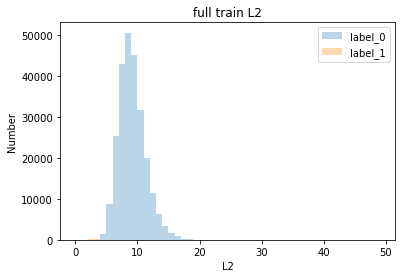

In [639]:
L2_full, label_full = shuffle(L2_full, label_full)

# Histgram
bins = np.arange(50)

plt.hist(L2_label_0_full, bins=bins, alpha=0.3, label='label_0')
plt.hist(L2_label_1_full, bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('full train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

In [640]:
def generate_roc(L2, label):
    FAR_array = []
    FRR_array = []
    for threshold in np.arange(np.amin(L2, axis=0), np.amax(L2, axis=0), 0.005):
        predict = []
        for l2 in L2:
            if l2 <= threshold:
                predict.append(1.0)
            else:
                predict.append(0.0)
        FAR, FRR = cal_FAR_FRR(label, predict)
        FAR_array.append(FAR)
        FRR_array.append(FRR)
        f1 = plt.figure(1)  
        plt.scatter(FAR_array,FRR_array) 
        
    return FAR_array, FRR_array

### Find EER
def find_EER(FAR_array, FRR_array):
    min_FAR = 1000
    min_FRR = 0
    for FAR, FRR in zip(FAR_array, FRR_array):
        if abs(FAR - FRR) < abs(min_FAR - min_FRR):
            min_FAR, min_FRR = FAR, FRR
    return (min_FAR + min_FRR)/2.0

KeyboardInterrupt: 

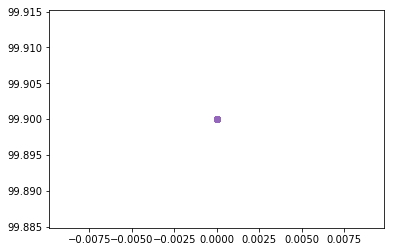

In [641]:
FAR_full, FRR_full = generate_roc(L2_full, label_full)
find_EER(FAR_full, FRR_full)

In [513]:
x=np.concatenate([np.reshape(FAR_array, [len(FAR_array),1]), np.reshape(FRR_array, [len(FRR_array),1])], axis=1)

### Select the best K

In [447]:
select_k(50, np.concatenate([L2_label_1_full, L2_label_0_full], axis=0), np.concatenate([label_1_full, label_0_full], axis=0), 
         np.concatenate([L2_label_1_test_full, L2_label_0_test_full], axis=0), np.concatenate([label_1_test_full,label_0_test_full],axis=0))

(7, 0.010821643286573146, 25.8)

In [260]:
L2_label_1_full, label_1_full, L2_label_0_full, label_0_full = calculate_L2(gallery_full[:500], probe_full[:500])
L2_label_1_test_full, label_1_test_full, L2_label_0_test_full, label_0_test_full = calculate_L2(gallery_full[500:], probe_full[500:])

In [457]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(np.concatenate([L2_label_1_full, L2_label_0_full], axis=0), 
          np.concatenate([label_1_full, label_0_full], axis=0))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [458]:
pred_full_proba = neigh.predict_proba(np.concatenate([L2_label_1_test_full, L2_label_0_test_full], axis=0))
# pred_full = neigh.predict(np.concatenate([L2_label_1_test_full, L2_label_0_test_full], axis=0))

In [459]:
cal_FAR_FRR(np.concatenate([label_1_test_full,label_0_test_full],axis=0), pred_full)

(0.0056112224448897794, 26.8, 14, 249500, 134, 500)

In [400]:
pred_full[100:200]

array([ 0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.])

In [450]:
FAR_array = []
FRR_array = []
for threshold in np.arange(0.0, 1.0, 0.01):
    new_predicted_results = according_proba_get_pred(threshold, pred_full_proba)
    FAR, FRR = cal_FAR_FRR(np.concatenate([label_1_test_full, label_0_test_full], axis=0), new_predicted_results)
    FAR_array.append(FAR)
    FRR_array.append(FRR)

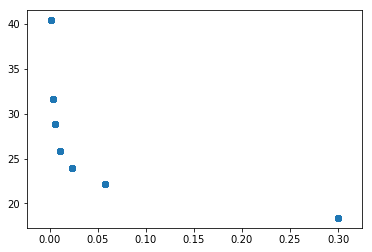

In [451]:
from numpy import * 
import random as rand
import matplotlib  
import matplotlib.pyplot as plt 

# x = rand.randint(50,30)

#basic  
f1 = plt.figure(1)  
# plt.subplot(211)  
plt.scatter(FAR_array,FRR_array)  
  
# # with legend  
# f2 = plt.figure(2)  
# idx_1 = find(label==1)  
# p1 = plt.scatter(x[idx_1,1], x[idx_1,0], marker = 'x', color = 'm', label='1', s = 30)  
# idx_2 = find(label==2)  
# p2 = plt.scatter(x[idx_2,1], x[idx_2,0], marker = '+', color = 'c', label='2', s = 50)  
# idx_3 = find(label==3)  
# p3 = plt.scatter(x[idx_3,1], x[idx_3,0], marker = 'o', color = 'r', label='3', s = 15)  
# plt.legend(loc = 'upper right') 

## Accuracy of pred GEI

## set L2 as threshold

In [642]:
fla_gallery_pred = flatten(pred_gallery_full)
fla_probe_pred = flatten(pred_probe_full)

In [643]:
# zero mean
pred_gallery_mean_value = np.sum(np.concatenate([pred_gallery_full[:500], pred_probe_full[:500]], axis=0)) / (1000 * 64 * 64)
zeromean_gallery_pred = fla_gallery_pred - pred_gallery_mean_value
zeromean_probe_pred = fla_probe_pred - pred_gallery_mean_value

In [645]:
# pca
pca = PCA(n_components=0.99)
pca_pred = pca.fit_transform(np.concatenate([zeromean_gallery_pred, zeromean_probe_pred], axis=0))
# pca_probe_full = pca.fit_transform(zeromean_probe_full)

In [646]:
L2_label_1_Pred, label_1_Pred, L2_label_0_Pred, label_0_Pred = calculate_L2(pca_pred[:500], pca_pred[1000:1500])
L2_label_1_test_Pred, label_1_test_Pred, L2_label_0_test_Pred, label_0_test_Pred = calculate_L2(pca_pred[500:1000], pca_pred[1500:2000])

In [649]:
L2_pred = np.concatenate([L2_label_1_Pred,L2_label_0_Pred,L2_label_1_test_Pred,L2_label_0_test_Pred], axis=0)
label_pred = np.concatenate([label_1_Pred,label_0_Pred,label_1_test_Pred,label_0_test_Pred], axis=0)

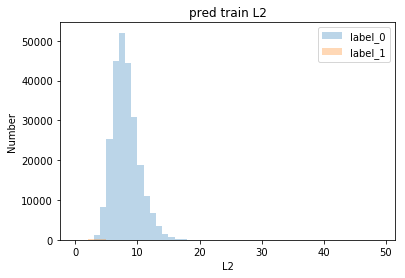

In [654]:
L2_pred, label_pred = shuffle(L2_pred, label_pred)

# Histgram
bins = np.arange(50)

plt.hist(L2_label_0_test_Pred, bins=bins, alpha=0.3, label='label_0')
plt.hist(L2_label_1_test_Pred, bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('pred train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

In [572]:
def generate_roc(L2, label):
    FAR_array = []
    FRR_array = []
    for threshold in np.arange(np.amin(L2, axis=0), np.amax(L2, axis=0), 0.005):
        predict = []
        for l2 in L2:
            if l2 <= threshold:
                predict.append(1.0)
            else:
                predict.append(0.0)
        FAR, FRR = cal_FAR_FRR(label, predict)
        FAR_array.append(FAR)
        FRR_array.append(FRR)
        f1 = plt.figure(1)  
        plt.scatter(FAR_array,FRR_array) 
        f1 = plt.figure(1)  
        plt.scatter(FAR_array,FRR_array) 
    return FAR_array, FRR_array

### Find EER
def find_EER(FAR_array, FRR_array):
    min_FAR = 1000
    min_FRR = 0
    for FAR, FRR in zip(FAR_array, FRR_array):
        if abs(FAR - FRR) < abs(min_FAR - min_FRR):
            min_FAR, min_FRR = FAR, FRR
    return (min_FAR + min_FRR)/2.0

8.108517034068136

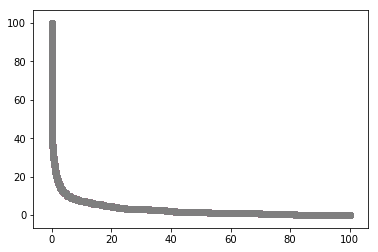

In [573]:
FAR_pred, FRR_pred = generate_roc(L2_pred, label_pred)
find_EER(FAR_pred, FRR_pred)

In [ ]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

## KNN

In [658]:
L2_label_1_Pred, label_1_Pred, L2_label_0_Pred, label_0_Pred = calculate_L2(pred_gallery_full[:500], pred_probe_full[:500])
L2_label_1_test_Pred, label_1_test_Pred, L2_label_0_test_Pred, label_0_test_Pred = calculate_L2(pred_gallery_full[500:], pred_probe_full[500:])

In [660]:
from sklearn.neighbors import KNeighborsClassifier
FAR_array = []
FRR_array = []
for k in range(1, 1000, 1):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(np.concatenate([L2_label_1_Pred, L2_label_0_Pred], axis=0), 
              np.concatenate([label_1_Pred, label_0_Pred], axis=0)) 
    pred_pred = neigh.predict(np.concatenate([L2_label_1_test_Pred, L2_label_0_test_Pred], axis=0))
    FAR, FRR = cal_FAR_FRR(np.concatenate([label_1_test_Pred,label_0_test_Pred],axis=0), pred_pred)
    FAR_array.append(FAR)
    FRR_array.append(FRR)

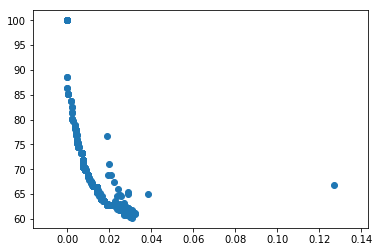

In [661]:
f1 = plt.figure(1)  
plt.scatter(FAR_array,FRR_array) 

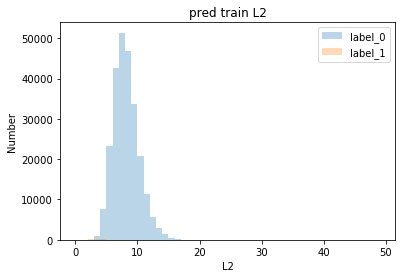

In [657]:
bins = np.arange(50)

plt.hist(L2_label_0_Pred, bins=bins, alpha=0.3, label='label_0')
plt.hist(L2_label_1_Pred, bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('pred train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

## Accuracy of 5f GEI

In [30]:
# map_5f, label_5f = calculate_L2(gallery_5f[:500], probe_5f_2[:500])
# map_5f_1, label_5f_1 = calculate_L2(gallery_5f[:500], probe_5f_3[:500])
# map_5f_2, label_5f_2 = calculate_L2(gallery_5f[:500], probe_5f[:500])
# map_5f_3, label_5f_3 = calculate_L2(gallery_5f_2[:500], probe_5f_2[:500])
# map_5f_4, label_5f_4 = calculate_L2(gallery_5f_2[:500], probe_5f_3[:500])
# map_5f_5, label_5f_5 = calculate_L2(gallery_5f_2[:500], probe_5f[:500])
# map_5f_6, label_5f_6 = calculate_L2(gallery_5f_3[:500], probe_5f_2[:500])
# map_5f_7, label_5f_7 = calculate_L2(gallery_5f_3[:500], probe_5f_3[:500])
# map_5f_8, label_5f_8 = calculate_L2(gallery_5f_3[:500], probe_5f[:500])

# MAP_5f = np.concatenate([map_5f,map_5f_1,map_5f_2,map_5f_3,map_5f_4,map_5f_5,map_5f_6,map_5f_7,map_5f_8], axis=0)
# Label_5f = np.concatenate([label_5f,label_5f_1,label_5f_2,label_5f_3,label_5f_4,label_5f_5,label_5f_6,label_5f_7,label_5f_8], axis=0)

## set L2 as threshold

In [562]:
L2_label_1_5f, label_1_5f, L2_label_0_5f, label_0_5f = calculate_L2(gallery_5f[:500], probe_5f[:500])
L2_label_1_test_5f, label_1_test_5f, L2_label_0_test_5f, label_0_test_5f = calculate_L2(gallery_5f[500:], probe_5f[500:])

In [563]:
L2_5f = np.concatenate([L2_label_1_5f,L2_label_0_5f,L2_label_1_test_5f,L2_label_0_test_5f], axis=0)
label_5f = np.concatenate([label_1_5f,label_0_5f,label_1_test_5f,label_0_test_5f], axis=0)

In [564]:
L2_5f, label_5f = shuffle(L2_5f, label_5f)

In [566]:
def generate_roc(L2, label):
    FAR_array = []
    FRR_array = []
    for threshold in np.arange(np.amin(L2, axis=0), np.amax(L2, axis=0), 0.005):
        predict = []
        for l2 in L2:
            if l2 <= threshold:
                predict.append(1.0)
            else:
                predict.append(0.0)
        FAR, FRR = cal_FAR_FRR(label, predict)
        FAR_array.append(FAR)
        FRR_array.append(FRR)
        f1 = plt.figure(1)  
        plt.scatter(FAR_array,FRR_array) 
        
    return FAR_array, FRR_array

### Find EER
def find_EER(FAR_array, FRR_array):
    min_FAR = 1000
    min_FRR = 0
    for FAR, FRR in zip(FAR_array, FRR_array):
        if abs(FAR - FRR) < abs(min_FAR - min_FRR):
            min_FAR, min_FRR = FAR, FRR
    return (min_FAR + min_FRR)/2.0

35.79348697394789

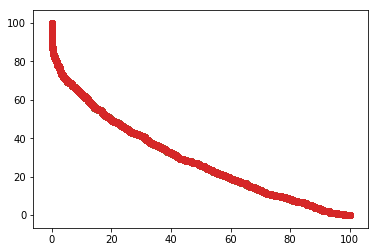

In [567]:
FAR_5f, FRR_5f = generate_roc(L2_5f, label_5f)
find_EER(FAR_5f, FRR_5f)

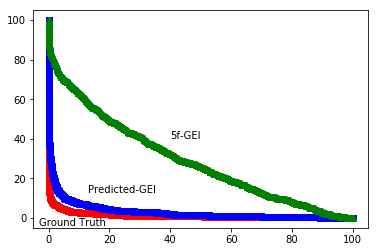

In [588]:
f1 = plt.figure(1)  
plt.scatter(FAR_array,FRR_array) 

plt.plot(FAR_array,FRR_array, 'r^', FAR_pred, FRR_pred, 'bs', FAR_5f, FRR_5f, 'g^')
plt.text(40, 40, r'5f-GEI')
plt.text(13, 13, r'Predicted-GEI')
plt.text(-3, -4, r'Ground Truth')
plt.show()

## KNN

In [490]:
L2_label_1_5f, label_1_5f, L2_label_0_5f, label_0_5f = calculate_L2(gallery_5f[:500], probe_5f[:500])
L2_label_1_test_5f, label_1_test_5f, L2_label_0_test_5f, label_0_test_5f = calculate_L2(gallery_5f[500:], probe_5f[500:])

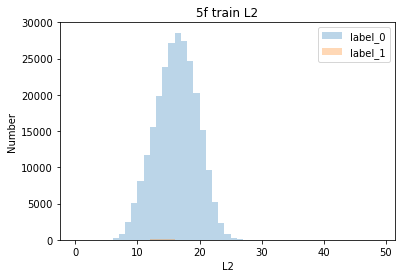

In [256]:
bins = np.arange(50)

plt.hist(L2_label_0_5f, bins=bins, alpha=0.3, label='label_0')
plt.hist(L2_label_1_5f, bins=bins, alpha=0.3, label='label_1')
# plt.hist(y_test, bins=bins, alpha=0.3, label='y_test')
plt.title('5f train L2')
plt.xlabel('L2')
plt.ylabel('Number')
plt.legend(loc='upper right')
 
plt.show()

In [253]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.concatenate([L2_label_1_5f, L2_label_0_5f], axis=0), 
          np.concatenate([label_1_5f, label_0_5f], axis=0)) 

# pred_5f = neigh.predict(np.concatenate([L2_label_1_test_5f, L2_label_0_test_5f[:500]], axis=0))
# calculate_acc(pred_5f, np.concatenate([label_1_test_5f, label_0_test_5f[:500]], axis=0))

pred_5f = neigh.predict(np.concatenate([L2_label_1_test_5f, L2_label_0_test_5f], axis=0))
calculate_acc(pred_5f, np.concatenate([label_1_test_5f, label_0_test_5f], axis=0))

99.632000000000005

ValueError: Number of features of the model must match the input. Model n_features is 1 and input n_features is 2 

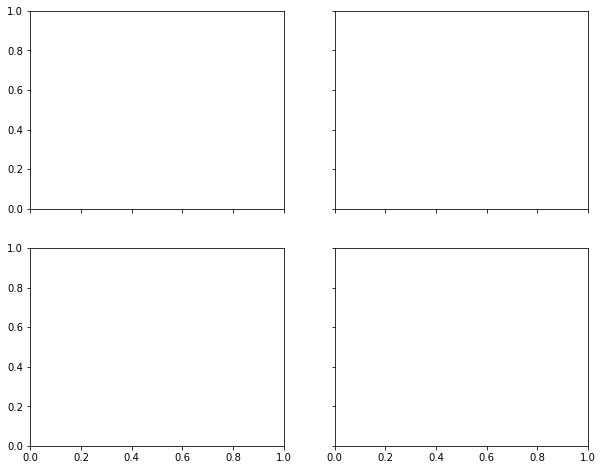

In [254]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
# iris = datasets.load_iris()
# X = iris.data[:, [0, 2]]
# y = iris.target

X = MAP_5f
y = Label_5f

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighmin_FAR, min_FRRbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:].min() - 1, X[:].max() + 1
y_min, y_max = 0 - 1, 1 + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

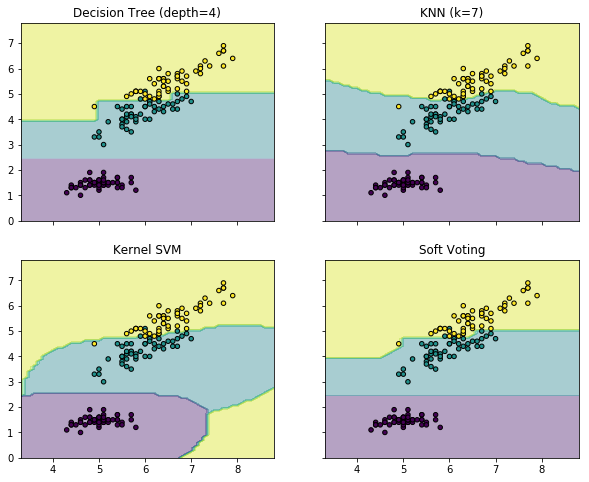

In [188]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Calculate SSIM and MSE

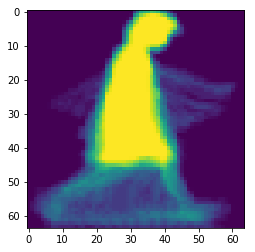

In [50]:
plt.imshow(gallery_full[0])

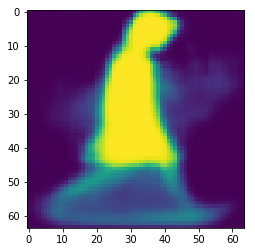

In [52]:
plt.imshow(pred_gallery_full_2[0])

In [79]:
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [103]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
 
def compare_images(imageA, imageB, title_1, title_2):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    # setup the figure
    fig = plt.figure()
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(title_1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(title_2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

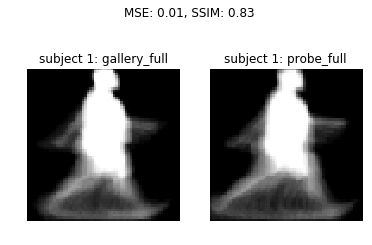

In [141]:
compare_images(gallery_full[1], probe_full[1], 'subject 1: gallery_full', 'subject 1: probe_full')

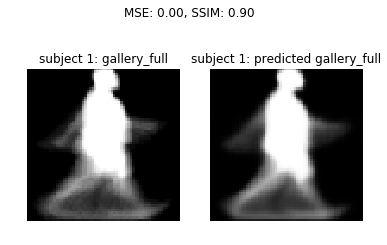

In [142]:
compare_images(gallery_full[1], pred_gallery_full[1], 'subject 1: gallery_full', 'subject 1: predicted gallery_full')

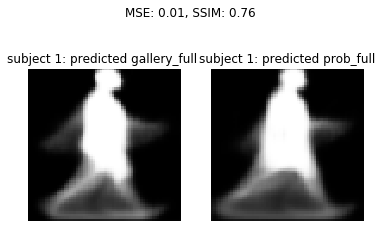

In [143]:
compare_images(pred_gallery_full[1], pred_probe_full[1], 'subject 1: predicted gallery_full ', 'subject 1: predicted prob_full')

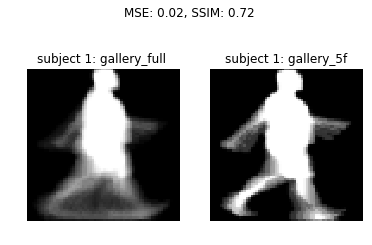

In [144]:
compare_images(gallery_full[1], gallery_5f[1], 'subject 1: gallery_full ', 'subject 1: gallery_5f')

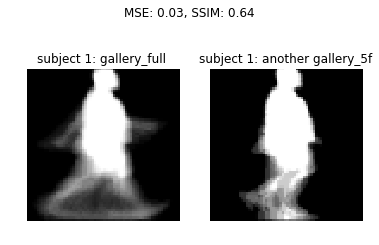

In [147]:
compare_images(gallery_full[1], gallery_5f_2[1], 'subject 1: gallery_full ', 'subject 1: another gallery_5f')

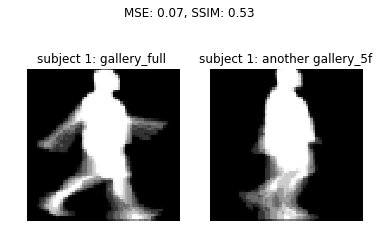

In [164]:
compare_images(gallery_5f[1], gallery_5f_2[1], 'subject 1: gallery_full ', 'subject 1: another gallery_5f')

In [170]:
np.sqrt(np.sum(np.square(gallery_5f[5] - probe_5f[2])))

12.43250876232695